# Generative Adverserial Network for Fake Image Generation

In this Notebook, we will train an FC-GAN to genereate fake Mnist data.

Followed by a conversion of the FC-GAN to DC-GAN, and the generation of higher resolution images.

Gan Paper: https://arxiv.org/abs/1406.2661

PyTorch MNist dataset : https://pytorch.org/docs/stable/torchvision/datasets.html#mnist

Convert FC-Gan To DC-Gan Paper : https://arxiv.org/pdf/1511.06434.pdf

List of tricks to train GANs: https://github.com/soumith/ganhacks

In [1]:
# Import the necessary modules

import os
from typing import Tuple, List

import torch
import torch.tensor as tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## FC-GAN for the Generation of Fake MNIST Data


In [2]:
# Frist load the MNist dataset from pytorch

def load_mnist_minibatched(batch_size: int, n_train: int = 8192, n_valid: int = 1024,
                           valid_test_batch_size: int = 1024) -> Tuple[DataLoader, DataLoader, DataLoader]:
    train_dataset = torchvision.datasets.MNIST(
        root='../data', train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = torchvision.datasets.MNIST(
        root='../data', train=False, transform=transforms.ToTensor())

    train_sampler = SubsetRandomSampler(range(n_train))
    validation_sampler = SubsetRandomSampler(range(n_train, n_train+n_valid))

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = DataLoader(dataset=train_dataset, batch_size=valid_test_batch_size,
                                   sampler=validation_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=valid_test_batch_size, 
                                              shuffle=False)
    return train_loader, validation_loader, test_loader

### This is what the MNist data looks like:

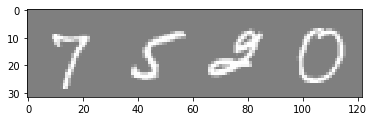

    7     5     2     0


In [3]:
batch_size = 32
trainloader, validation_loader, test_loader = load_mnist_minibatched(batch_size)

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

img = torchvision.utils.make_grid(images[:4,:,:,:])

# show images
img = img / 2 + 0.5     # unnormalize
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


### The adverserial Networks:



#### The Generative Network:

Input: x values sampled from uniform distribution

Output: 32 x 32 Image, that should look like the data from MNist 

In [12]:
# The Generative Network

class generativeNet(nn.Module):
    """
        The CNN convolutional network with architecture defined above
    """
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features= 10, out_features=6 * 6)
        
        self.fc2 = nn.Linear(in_features= 6 * 6, out_features=12 * 12)
        
        self.fc3 = nn.Linear(in_features= 12 * 12, out_features=24 * 24)
        
        self.fc4 = nn.Linear(in_features= 24 * 24, out_features=28 * 28)
        
        self.ReLU = nn.ReLU()
 
    def forward(self, x):
        """
        
        Args:
            x: The input tensor with shape [batch_size, feature_dim] (minibatch of data)
        Returns:
            scores: Pytorch tensor of shape (N, C) giving classification scores for x
        """
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.fc3(x)
        x = self.ReLU(x)
        x = self.fc4(x)        
        return x

#### The discriminative network:

Input: Takes 32 x 32 Image as Input
Output: probability of it being real data (non generated)

In [13]:


class discrimNet(nn.Module):
    """
        The CNN convolutional network with architecture defined above
    """
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features= 28 * 28, out_features=22 * 22)
        
        self.fc2 = nn.Linear(in_features= 22 * 22, out_features=12 * 12)
        
        self.fc3 = nn.Linear(in_features= 12 * 12, out_features=6 * 6)
        
        # 2 class fake and real data
        self.fc4 = nn.Linear(in_features= 6 * 6, out_features=2)
        
        self.ReLU = nn.ReLU()
        
        self.soft = nn.Softmax(dim=1)
        
        
    def forward(self, x):
        """
        Args:
            x: The input tensor with shape [batch_size, feature_dim] (minibatch of data)
        Returns:
            scores: Pytorch tensor of shape (N, C) giving classification scores for x
        """
        
        x = x.view(x.shape[0], 28 * 28)
    
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.fc3(x)
        x = self.ReLU(x)
        x = self.fc4(x)        
        return self.soft(x)

### Define The Noise Prior for the Generative Network:

In [14]:
# Define The Noise Distribution, we us the Gaussian Nosie Distribution:

# always use the same seed to get the same random variables
# np.random.seed(0)

# Here is how to sample a vector of 10 values from uniform distribution
s = np.random.uniform(0,1, 10)
print(s)

[0.64629791 0.23419249 0.68541793 0.76016939 0.34297624 0.24666436
 0.80726976 0.06034769 0.98901611 0.3604719 ]


### Simple helper functions


In [15]:
# function for sampling the noise data

def sample_noise(batch_size=batch_size):
    noise_batch = []
    for i in range(batch_size):
        s = np.random.uniform(0,1, 10) # 10 values sample from uniform distribution
        noise_batch.append(s)

    noise_batch = torch.from_numpy(np.asarray(noise_batch)).float() 
    return noise_batch

In [31]:
# function to plot the losses

def plot_losses(loss_g, loss_d):
    xg = [i for i in range(len(loss_g))]
    xd = [i for i in range(len(loss_d))]
    plt.plot( loss_g, label='g')
    plt.plot( loss_d, label='d')

    plt.xlabel('Iterations')
    plt.ylabel('Loss')

    plt.title("Loss of D ang G")

    plt.legend()

    plt.show()

### Train the Networks:

In [32]:
torch.cuda.get_device_capability(device=None)
torch.cuda.get_device_name(device=None)

'GeForce GTX 1050'

In [33]:
# calculate the real labels
a_real = []
a_fake = []
for i in range(batch_size):
    sub1 = [1]
    sub2 = [0]
    for j in range(1):
        sub1.append(0)
        sub2.append(1)
    a_real.append(sub1)
    a_fake.append(sub2)

labels_real = torch.tensor(a_real, dtype=torch.float).cuda()
labels_fake = torch.tensor(a_fake, dtype=torch.float).cuda()

In [34]:
G = generativeNet()
D = discrimNet()
G.to(device)
D.to(device)

# Define a Loss function and optimizer
optimizer1 = optim.SGD(D.parameters(), lr=0.0001, momentum=0.9)
optimizer2 = optim.SGD(G.parameters(), lr=0.0001, momentum=0.9)
# k = discriminator interations
k = 3

criterion = nn.BCELoss()

loss_g = []
loss_d = []

# Train the network
for epoch in range(100):
    print("Currently running epoch Nbr %d" % epoch)
    
    # train D for k iterations 
    for d in range(k):
        #print("\tRunning D iteration Nbr %d" % d)
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer1.zero_grad()
            # sample batch_size * 10 matrix of uniform distributed noise
            noise = sample_noise(batch_size).to(device)
            outputs_fake = D(G(noise).detach())
            outputs_real = D(inputs)
            loss = criterion(outputs_real, labels_real) + criterion(outputs_fake, labels_fake)
            loss.backward()
            optimizer1.step()
            running_loss += loss.item()
            if i % 100 == 99:   # print every 1000 mini-batches
                print('\t[%d, %5d] D loss: %.9f' %
                      (d + 1, i + 1, running_loss / 99))
                loss_d.append(running_loss)
                running_loss = 0.0

    # 1 training step for G
    print("\t\t Running %dth iteration on G" % epoch)
    running_loss = 0.0
    for i in range(200):
        optimizer2.zero_grad()
        noise = sample_noise(batch_size).to(device)
        loss = criterion(D(G(noise)), labels_fake)
        loss.backward()
        optimizer2.step()
        running_loss += loss.item()
        if i % 100 == 99:   # print every 1000 mini-batches
                print('\t[%d, %5d] G loss: %.9f' %
                      (d + 1, i + 1, running_loss / 99))
                loss_g.append(running_loss)
                running_loss = 0.0

print('Finished Training')

Currently running epoch Nbr 0
	[1,   100] D loss: 1.401772107
	[1,   200] D loss: 1.392696216
	[2,   100] D loss: 1.380007989
	[2,   200] D loss: 1.371098682
	[3,   100] D loss: 1.355137547
	[3,   200] D loss: 1.341766296
		 Running 0th iteration on G
	[3,   100] G loss: 0.681984059
	[3,   200] G loss: 0.681750427
Currently running epoch Nbr 1
	[1,   100] D loss: 1.315697194
	[1,   200] D loss: 1.294366945
	[2,   100] D loss: 1.248953393
	[2,   200] D loss: 1.206604366
	[3,   100] D loss: 1.109246371
	[3,   200] D loss: 1.023026034
		 Running 1th iteration on G
	[3,   100] G loss: 0.569845327
	[3,   200] G loss: 0.569202176
Currently running epoch Nbr 2
	[1,   100] D loss: 0.856606588
	[1,   200] D loss: 0.748371775
	[2,   100] D loss: 0.606667112
	[2,   200] D loss: 0.534019042
	[3,   100] D loss: 0.443598435
	[3,   200] D loss: 0.398016149
		 Running 2th iteration on G
	[3,   100] G loss: 0.310141228
	[3,   200] G loss: 0.309947436
Currently running epoch Nbr 3
	[1,   100] D loss: 0.

	[3,   200] G loss: 0.002781700
Currently running epoch Nbr 26
	[1,   100] D loss: 0.003387081
	[1,   200] D loss: 0.003196521
	[2,   100] D loss: 0.003226969
	[2,   200] D loss: 0.003031319
	[3,   100] D loss: 0.003306158
	[3,   200] D loss: 0.003087214
		 Running 26th iteration on G
	[3,   100] G loss: 0.002609076
	[3,   200] G loss: 0.002606111
Currently running epoch Nbr 27
	[1,   100] D loss: 0.002981663
	[1,   200] D loss: 0.003184664
	[2,   100] D loss: 0.002999419
	[2,   200] D loss: 0.003039499
	[3,   100] D loss: 0.002913310
	[3,   200] D loss: 0.002846684
		 Running 27th iteration on G
	[3,   100] G loss: 0.002454201
	[3,   200] G loss: 0.002450064
Currently running epoch Nbr 28
	[1,   100] D loss: 0.003070909
	[1,   200] D loss: 0.002782695
	[2,   100] D loss: 0.002818718
	[2,   200] D loss: 0.002888303
	[3,   100] D loss: 0.002814068
	[3,   200] D loss: 0.002839642
		 Running 28th iteration on G
	[3,   100] G loss: 0.002309068
	[3,   200] G loss: 0.002308474
Currently runn

		 Running 51th iteration on G
	[3,   100] G loss: 0.000897439
	[3,   200] G loss: 0.000896789
Currently running epoch Nbr 52
	[1,   100] D loss: 0.001071276
	[1,   200] D loss: 0.001080331
	[2,   100] D loss: 0.001094623
	[2,   200] D loss: 0.001054077
	[3,   100] D loss: 0.001082644
	[3,   200] D loss: 0.001075710
		 Running 52th iteration on G
	[3,   100] G loss: 0.000870959
	[3,   200] G loss: 0.000871235
Currently running epoch Nbr 53
	[1,   100] D loss: 0.001075107
	[1,   200] D loss: 0.001016324
	[2,   100] D loss: 0.001065020
	[2,   200] D loss: 0.001042593
	[3,   100] D loss: 0.001089802
	[3,   200] D loss: 0.000988913
		 Running 53th iteration on G
	[3,   100] G loss: 0.000845894
	[3,   200] G loss: 0.000846125
Currently running epoch Nbr 54
	[1,   100] D loss: 0.001030180
	[1,   200] D loss: 0.001034807
	[2,   100] D loss: 0.001054046
	[2,   200] D loss: 0.001009253
	[3,   100] D loss: 0.000962289
	[3,   200] D loss: 0.001073407
		 Running 54th iteration on G
	[3,   100] G l

	[3,   100] D loss: 0.000563510
	[3,   200] D loss: 0.000598584
		 Running 77th iteration on G
	[3,   100] G loss: 0.000484974
	[3,   200] G loss: 0.000484358
Currently running epoch Nbr 78
	[1,   100] D loss: 0.000626674
	[1,   200] D loss: 0.000560046
	[2,   100] D loss: 0.000624044
	[2,   200] D loss: 0.000587166
	[3,   100] D loss: 0.000556468
	[3,   200] D loss: 0.000588284
		 Running 78th iteration on G
	[3,   100] G loss: 0.000475574
	[3,   200] G loss: 0.000475549
Currently running epoch Nbr 79
	[1,   100] D loss: 0.000586209
	[1,   200] D loss: 0.000597816
	[2,   100] D loss: 0.000591270
	[2,   200] D loss: 0.000597974
	[3,   100] D loss: 0.000586568
	[3,   200] D loss: 0.000579046
		 Running 79th iteration on G
	[3,   100] G loss: 0.000467670
	[3,   200] G loss: 0.000466811
Currently running epoch Nbr 80
	[1,   100] D loss: 0.000572445
	[1,   200] D loss: 0.000579996
	[2,   100] D loss: 0.000577889
	[2,   200] D loss: 0.000582520
	[3,   100] D loss: 0.000552442
	[3,   200] D 

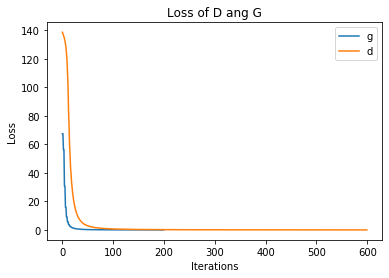

In [36]:
plot_losses(loss_g, loss_d)

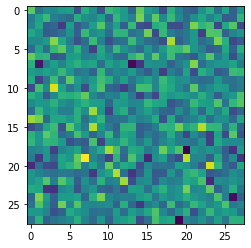

tensor([[3.4167e-04, 9.9966e-01]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 3.5059e-06]], device='cuda:0', grad_fn=<SoftmaxBackward>)


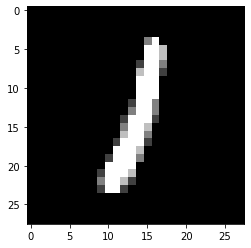

In [39]:
s = sample_noise(1).cuda()

a = G(s)

a = torch.reshape(G(s), (28,28)).cpu()
img = torchvision.utils.make_grid(a)

img = img / 2 + 0.5     # unnormalize
npimg = img.detach().numpy()
#plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.imshow(np.transpose(a.detach().numpy(), (0, 1)))
plt.show()


print(D(G(s).detach()))


trainloader, validation_loader, test_loader = load_mnist_minibatched(batch_size)

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(D(images[0].to(device)))

img = torchvision.utils.make_grid(images[0])

#img = img / 2 + 0.5
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
